In [1]:
import VariationalBayes.Parameters as par
from VariationalBayes.MultinomialParams import SimplexParam

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import copy
from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, 3 ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, 2 ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


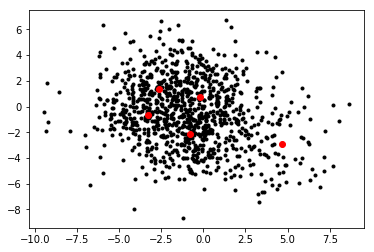

In [3]:
# Never a bad idea to visualize the dataz

plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [25]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
global_params = par.ModelParamsDict('global')

global_params.push_param(
    par.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    par.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    SimplexParam(name='pi', shape=(1, k_num)))

local_params = par.ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(n_num, k_num), val=np.full(true_z.shape, 1. / k_num)))

params = par.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ inf  inf]
 [ inf  inf]
 [ inf  inf]
 [ inf  inf]
 [ inf  inf]]
	pi: [[ 0.2  0.2  0.2  0.2  0.2]]


In [13]:
prior_params = par.ModelParamsDict()
prior_params.push_param(par.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(par.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(par.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(par.ScalarParam(name='dof', val=d_num + 2.0))

In [14]:
def data_log_likelihood(mu, info, e_z, x):
    k_num = e_z.shape[1]
    assert k_num == mu.shape[0]
    assert k_num == info.shape[0]
    log_lik = 0.0
    # I would be interested to see how this could work without a loop.
    for k in range(k_num):
        x_centered = x - np.expand_dims(mu[k, :], axis=0)
        log_lik = log_lik - 0.5 * np.einsum('ni, ij, nj, n', x_centered, info[k, :, :], x_centered, e_z[:, k])
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        assert sign > 0
        log_lik = log_lik + 0.5 * logdet * np.sum(e_z[:, k])
    return log_lik

def indicator_log_likelihood(e_z, pi):
    return np.sum(np.matmul(e_z, np.log(pi.T)))

def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))
    

e_z = params['local']['e_z'].get()
data_log_likelihood(true_mu, true_info, e_z, x)
indicator_log_likelihood(e_z, true_pi)
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

1609.4379124341003

In [15]:
def get_multinoulli_expectation(natural_parameters):
    z_logsumexp = np.expand_dims(sp.misc.logsumexp(natural_parameters, 1), axis=1)
    return np.exp(natural_parameters - z_logsumexp)


In [16]:
class Objective(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        
        self.kl_grad = autograd.grad(self.kl_wrapper)
        self.kl_hessian = autograd.hessian(self.kl_wrapper)
        self.kl_hvp = autograd.hessian_vector_product(self.kl_wrapper)

        self.global_kl_grad = autograd.grad(self.global_kl_wrapper)
        self.global_kl_hvp = autograd.hessian_vector_product(self.global_kl_wrapper)

        self.get_z_nat_params = autograd.grad(self.expected_log_likelihood, argnum=0)
        
    def expected_log_likelihood(self, e_z, mu, info, pi):
        elbo = 0.0

        # Data:
        elbo += data_log_likelihood(mu, info, e_z, self.x)
        elbo += indicator_log_likelihood(e_z, pi)
        
        # Priors:
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        elbo += mu_prior(mu, mu_prior_mean, mu_prior_info)
        elbo += pi_prior(pi, self.prior_params['alpha'].get())
        elbo += info_prior(info, self.prior_params['dof'].get())

        return elbo
    
    def optimize_z(self):
        # Take a CAVI step on Z.
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['local']['e_z'].get()

        natural_parameters = obj.get_z_nat_params(e_z, mu, info, pi)
        self.params['local']['e_z'].set(get_multinoulli_expectation(natural_parameters))
    
    def kl(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['local']['e_z'].get()

        elbo = self.expected_log_likelihood(e_z, mu, info, pi)
        elbo += multinoulli_entropy(e_z)
        
        return -1 * elbo

    def kl_wrapper(self, free_params, verbose=False):
        self.params.set_free(free_params)
        kl = self.kl()
        if verbose:
            print(kl)
        return kl

    def global_kl_wrapper(self, global_free_params, verbose=False):
        self.params['global'].set_free(global_free_params)
        kl = self.kl()
        if verbose:
            print(kl)
        return kl



In [17]:
obj = Objective(x, params, prior_params)
free_par = params.get_free()
global_free_par = params['global'].get_free()
obj.kl_wrapper(free_par)

grad = obj.kl_grad(free_par)
hvp = obj.kl_hvp(free_par, grad)

grad = obj.global_kl_grad(global_free_par)
hvp = obj.global_kl_hvp(global_free_par, grad)

obj.optimize_z()


In [23]:

obj.params.set_free(init_par_vec)
obj.optimize_z()
print(obj.params)
kl = obj.kl()
print(kl)

mixture model:
	global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ inf  inf]
 [ inf  inf]
 [ inf  inf]
 [ inf  inf]
 [ inf  inf]]
	pi: [[ 0.2  0.2  0.2  0.2  0.2]]
	local:
	e_z: [[ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 ..., 
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]]
nan


In [18]:

obj.params.set_free(init_par_vec)
global_param_vec = obj.params['global'].get_vector()
kl = obj.kl()

for step in range(50):
    global_free_par = obj.params['global'].get_free()
    global_vb_opt = optimize.minimize(
        lambda par: obj.global_kl_wrapper(par, verbose=False),
        x0=global_free_par, jac=obj.global_kl_grad, hessp=obj.global_kl_hvp,
        method='nelder-mead', options={'maxiter': 50})
    obj.params['global'].set_free(global_vb_opt.x)
    obj.optimize_z()

    new_global_param_vec = obj.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = obj.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl = {}\t\tdiff = {}'.format(kl_diff, diff))
    
print(obj.params)
print('Done.')

/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:389: RuntimeWarning: Method nelder-mead does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/optimize.py:527: RuntimeWarning: invalid value encountered in subtract
  if (numpy.max(numpy.ravel(numpy.abs(sim[1:] - sim[0]))) <= xatol and
/usr/local/lib/python3.5/dist-packages/scipy/optimize/optimize.py:532: RuntimeWarning: invalid value encountered in subtract
  xr = (1 + rho) * xbar - rho * sim[-1]
/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/VariationalBayes/Parameters.py:237: RuntimeWarning: invalid value encountered in less
  if (val < self.__lb).any():
/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Vari

 kl = nan		diff = nan
 kl = nan		diff = nan


KeyboardInterrupt: 

In [ ]:
opt_params = deepcopy(params)
opt_params.set_free(vb_opt.x)
print(opt_params)
print('True mu = ', true_mu)
print('True pi = ', true_pi)